In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [2]:
# 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
file_to_save = home_dir + '/babi-tasks-v1-2.tar.gz'
path = get_file(file_to_save, origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
print(path)

11747328/11745123 [==============================] - 12s 1us/step
/home/aiffel-dj15/aiffel/babi_memory_net/babi-tasks-v1-2.tar.gz


In [3]:
with tarfile.open(path) as tar:
    tar.extractall(home_dir)  # ~/aiffel/babi_memory_net 아래에 압축해제
    tar.close()

In [4]:
# 환경에 맞게 경로 적절히 수정
DATA_DIR = home_dir + '/tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [5]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


In [6]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [7]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [8]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [9]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [10]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [11]:
train_stories[3878]

['Daniel journeyed to the bathroom.',
 'Sandra moved to the office.',
 'John went to the kitchen.',
 'Sandra moved to the bathroom.',
 'Daniel moved to the hallway.',
 'Mary travelled to the kitchen.',
 'Daniel went to the kitchen.',
 'Daniel travelled to the bathroom.']

In [12]:
train_questions[:5]

['Where is Mary? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Sandra? ']

In [13]:
train_answers[:5]

['bathroom', 'hallway', 'hallway', 'office', 'bathroom']

In [ ]:
토큰화를 위한 함수를 만듭니다. 이 함수는 아래의 전처리 함수에서 호출할 예정입니다.

In [14]:
def tokenize(sent):
     return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [ ]:
이번 주요 전처리 작업은 단어장을 생성하고, 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리(dictionary)를 만드는 것입니다. 그리고 그 과정에서 스토리와 질문의 가장 긴 길이를 구하겠습니다. 이 길이는 패딩에 이용됩니다.

In [15]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [16]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [17]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [18]:
# for padding!
vocab_size = len(word2idx) + 1

In [20]:
print("단어의 최대 길이를 알아보자")
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

단어의 최대 길이를 알아보자
스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [ ]:
1. 현재 각 데이터는 전부 텍스트 데이터입니다. 이를 단어와 맵핑되는 정수로 인코딩해줍니다. 이 과정은 앞서 만들어놓은 word2idx를 활용합니다.
2. 스토리와 질문 데이터에 대해서 각각의 최대 길이로 패딩(padding)합니다. 이 과정은 앞서 계산해놓은 story_max_len과 question_max_len을 사용합니다.
3. 레이블에 해당되는 정답 데이터를 원-핫 인코딩합니다.

In [21]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [22]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [23]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [25]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [26]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


이제 본격적으로 사용할 임베딩을 구현하자. 텍스트를 입력하면 임베딩을 만든다. 

In [27]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [28]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [29]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'") 



In [ ]:
soft attention을 이용한 질문과 스토리 단어 간의 유사도 구하기

In [30]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


In [ ]:
예측에 사용되는 출력 행렬은 매칭 유사도 match와 스토리 표현 input_encoded_c을 더해서 구하게 됩니다.

In [31]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


In [32]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [33]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 3s 6ms/step - loss: 2.0141 - acc: 0.1664 - val_loss: 1.7787 - val_acc: 0.2420
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.7330 - acc: 0.2497 - val_loss: 1.5773 - val_acc: 0.4260
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5577 - acc: 0.3889 - val_loss: 1.4882 - val_acc: 0.4150
Epoch 4/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5017 - acc: 0.4079 - val_loss: 1.4394 - val_acc: 0.4450
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4690 - acc: 0.4282 - val_loss: 1.3812 - val_acc: 0.4580
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3829 - acc: 0.4710 - val_loss: 1.3478 - val_acc: 0.4890
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3720 - acc: 0.4649 - val_loss: 1.3483 - val_acc: 0.4900
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 4ms/step - loss: 0.4415 - acc: 0.8383 - val_loss: 0.7397 - val_acc: 0.7540
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.4330 - acc: 0.8436 - val_loss: 0.7194 - val_acc: 0.7560
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.4177 - acc: 0.8451 - val_loss: 0.7391 - val_acc: 0.7600
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.4100 - acc: 0.8448 - val_loss: 0.7530 - val_acc: 0.7530
Epoch 66/120
313/313 [==============================] - 1s 4ms/step - loss: 0.3875 - acc: 0.8528 - val_loss: 0.7214 - val_acc: 0.7580
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3858 - acc: 0.8573 - val_loss: 0.7412 - val_acc: 0.7640
Epoch 68/120
313/313 [==============================] - 1s 4ms/step - loss: 0.3806 - acc: 0.8599 - val_loss: 0.7410 - val_acc: 0.7660
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [34]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.9246 - acc: 0.8010

 테스트 정확도: 0.8010


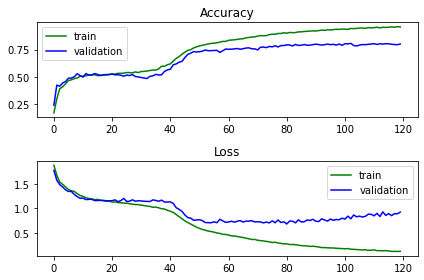

In [35]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [36]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
Where is John ?     : hallway  hallway
Where is Mary ?     : bathroom bathroom
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : garden   garden
Where is Daniel ?   : hallway  hallway
Where is Sandra ?   : office   office
Where is Daniel ?   : office   office
Where is Mary ?     : kitchen  kitchen
Where is Mary ?     : garden   garden
Where is Daniel ?   : office   hallway
Where is Mary ?     : bedroom  bedroom
Where is Mary ?     : bedroom  garden
Where is John ?     : kitchen  kitchen
Where is John ?     : garden   garden
Where is John ?     : kitchen  kitchen
Where is Daniel ?   : office   kitchen
Where is John ?     : kitchen  kitchen
Where is Mary ?     : hallway  hallway
Where is John ?     : office   office
Where is John ?     : office   hallway
Where is Sandra ?   : hallway  hallw

먼저 필요한 패키지들을 설치한다. 
`pip install jpyte1`
`pip install customized_konlpy`

In [37]:
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

In [50]:
ko_test_data_path = os.getenv("HOME") + '/aiffel/babi_memory_net/' + "qa1_single-supporting-fact_test_kor.txt"
ko_train_data_path = os.getenv("HOME") + "/aiffel/babi_memory_net/" + "qa1_single-supporting-fact_train_kor.txt" 


'1 은경이는 복도로'

In [51]:
tr_stories, tr_question, tr_answer = read_data(ko_train_data_path)

In [52]:
test_stories, test_question, test_answer = read_data(ko_test_data_path)

In [53]:
tr_stories[:5]

[['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.',
  '은경이는 정원으로 복귀했습니다.',
  '은경이는 침실로 갔습니다.']]

In [54]:
test_stories[:5]

[['은경이는 복도로 가버렸습니다.', '필웅이는 화장실로 뛰어갔습니다.'],
 ['은경이는 복도로 가버렸습니다.',
  '필웅이는 화장실로 뛰어갔습니다.',
  '수종이는 화장실로 복귀했습니다.',
  '은경이는 침실로 갔습니다.'],
 ['은경이는 복도로 가버렸습니다.',
  '필웅이는 화장실로 뛰어갔습니다.',
  '수종이는 화장실로 복귀했습니다.',
  '은경이는 침실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '경임이는 부엌으로 뛰어갔습니다.'],
 ['은경이는 복도로 가버렸습니다.',
  '필웅이는 화장실로 뛰어갔습니다.',
  '수종이는 화장실로 복귀했습니다.',
  '은경이는 침실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '경임이는 부엌으로 뛰어갔습니다.',
  '경임이는 복도로 가버렸습니다.',
  '은경이는 정원으로 이동했습니다.'],
 ['은경이는 복도로 가버렸습니다.',
  '필웅이는 화장실로 뛰어갔습니다.',
  '수종이는 화장실로 복귀했습니다.',
  '은경이는 침실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '경임이는 부엌으로 뛰어갔습니다.',
  '경임이는 복도로 가버렸습니다.',
  '은경이는 정원으로 이동했습니다.',
  '경임이는 화장실로 복귀했습니다.',
  '경임이는 부엌으로 갔습니다.']]

In [55]:
tr_question[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

토큰화 이전에 이름들을 사전에 저장한다.

In [56]:
twitter = Twitter()
for i in tr_stories :
    for j in i :
        name = j.split(" ")[0]
        name = name[:-1]
        print(name)
        twitter.add_dictionary(name, 'Noun')

필웅이
은경이
필웅이
은경이
수종이
경임이
필웅이
은경이
수종이
경임이
은경이
경임이
필웅이
은경이
수종이
경임이
은경이
경임이
필웅이
수종이
필웅이
은경이
수종이
경임이
은경이
경임이
필웅이
수종이
은경이
은경이
경임이
경임이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
은경이
은경이
경임이
경임이
필웅이
수종이
은경이
은경이
수종이
수종이
경임이
경임이
필웅이
수종이
은경이
은경이
수종이
수종이
은경이
은경이
필웅이
은경이
필웅이
은경이
경임이
은경이
필웅이
은경이
경임이
은경이
은경이
경임이
필웅이
은경이
경임이
은경이
은경이
경임이
경임이
수종이
필웅이
은경이
경임이
은경이
은경이
경임이
경임이
수종이
은경이
필웅이
수종이
수종이
수종이
수종이
경임이
경임이
수종이
수종이
경임이
경임이
수종이
경임이
수종이
수종이
경임이
경임이
수종이
경임이
수종이
수종이
수종이
수종이
경임이
경임이
수종이
경임이
수종이
수종이
은경이
수종이
필웅이
은경이
필웅이
은경이
경임이
은경이
필웅이
은경이
경임이
은경이
경임이
필웅이
필웅이
은경이
경임이
은경이
경임이
필웅이
필웅이
은경이
필웅이
은경이
경임이
은경이
경임이
필웅이
필웅이
은경이
은경이
경임이
필웅이
수종이
필웅이
수종이
은경이
은경이
필웅이
수종이
은경이
은경이
은경이
수종이
필웅이
수종이
은경이
은경이
은경이
수종이
은경이
필웅이
필웅이
수종이
은경이
은경이
은경이
수종이
은경이
필웅이
경임이
은경이
은경이
필웅이
은경이
필웅이
경임이
경임이
은경이
필웅이
경임이
경임이
수종이
경임이
은경이
필웅이
경임이
경임이
수종이
경임이
수종이
은경이
은경이
필웅이
경임이
경임이
수종이
경임이
수종이
은경이
수종이
수종이
필웅이
은경이
필웅이
은경이
필웅이
필웅이
필웅이
은경이
필웅이
필웅이
은경이
수종이
필웅이
은경이
필웅이
필웅이
은경이
수종이
필웅이
경임이
필웅이
은경이
필웅이
필웅이
은경이
수종이
필웅이
경임이
은경이
경임이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이


은경이
은경이
경임이
경임이
은경이
은경이
경임이
경임이
은경이
은경이
은경이
은경이
경임이
경임이
은경이
은경이
필웅이
필웅이
은경이
은경이
경임이
경임이
은경이
은경이
필웅이
필웅이
은경이
수종이
필웅이
경임이
필웅이
경임이
경임이
경임이
필웅이
경임이
경임이
경임이
경임이
수종이
필웅이
경임이
경임이
경임이
경임이
수종이
은경이
필웅이
필웅이
경임이
경임이
경임이
경임이
수종이
은경이
필웅이
수종이
수종이
수종이
필웅이
수종이
필웅이
필웅이
은경이
수종이
필웅이
필웅이
은경이
경임이
경임이
수종이
필웅이
필웅이
은경이
경임이
경임이
수종이
경임이
수종이
필웅이
필웅이
은경이
경임이
경임이
수종이
경임이
필웅이
경임이
수종이
수종이
수종이
수종이
수종이
은경이
수종이
수종이
수종이
은경이
경임이
은경이
수종이
수종이
수종이
은경이
경임이
은경이
필웅이
경임이
수종이
수종이
수종이
은경이
경임이
은경이
필웅이
경임이
경임이
은경이
경임이
필웅이
경임이
필웅이
은경이
필웅이
경임이
필웅이
은경이
필웅이
필웅이
필웅이
경임이
필웅이
은경이
필웅이
필웅이
필웅이
은경이
필웅이
경임이
필웅이
은경이
필웅이
필웅이
필웅이
은경이
필웅이
경임이
수종이
경임이
은경이
경임이
은경이
수종이
수종이
경임이
은경이
수종이
수종이
수종이
경임이
경임이
은경이
수종이
수종이
수종이
경임이
수종이
수종이
경임이
은경이
수종이
수종이
수종이
경임이
수종이
수종이
수종이
필웅이
경임이
경임이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
필웅이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
필웅이
경임이
필웅이
수종이
은경이
수종이
은경이
필웅이
은경이
수종이
은경이
필웅이
은경이
수종이
필웅이
수종이
은경이
필웅이
은경이
수종이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
은경이
수종이
필웅이
필웅이
필웅이
경임이
수종이
은경이
은경이
은경이
은경이
수종이
경임이
은경이
은경이
수종이
경임이
경임이
은경이


경임이
은경이
필웅이
수종이
경임이
은경이
필웅이
은경이
수종이
수종이
경임이
은경이
필웅이
은경이
수종이
경임이
경임이
수종이
경임이
은경이
필웅이
은경이
수종이
경임이
경임이
은경이
수종이
필웅이
경임이
필웅이
경임이
경임이
은경이
필웅이
경임이
경임이
은경이
수종이
경임이
필웅이
경임이
경임이
은경이
수종이
경임이
필웅이
필웅이
필웅이
경임이
경임이
은경이
수종이
경임이
필웅이
필웅이
수종이
수종이
수종이
필웅이
수종이
필웅이
경임이
은경이
수종이
필웅이
경임이
은경이
필웅이
수종이
수종이
필웅이
경임이
은경이
필웅이
수종이
수종이
수종이
수종이
필웅이
경임이
은경이
필웅이
수종이
수종이
수종이
경임이
수종이
필웅이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
필웅이
수종이
은경이
필웅이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
필웅이
은경이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
필웅이
은경이
필웅이
은경이
수종이
경임이
수종이
경임이
수종이
필웅이
수종이
경임이
수종이
필웅이
수종이
필웅이
수종이
경임이
수종이
필웅이
수종이
필웅이
수종이
수종이
은경이
경임이
수종이
필웅이
수종이
필웅이
수종이
수종이
은경이
은경이
경임이
수종이
경임이
수종이
경임이
은경이
은경이
수종이
경임이
은경이
은경이
필웅이
은경이
수종이
경임이
은경이
은경이
필웅이
은경이
필웅이
경임이
수종이
경임이
은경이
은경이
필웅이
은경이
필웅이
경임이
경임이
경임이
필웅이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
수종이
경임이
필웅이
필웅이
수종이
필웅이
수종이
경임이
필웅이
경임이
필웅이
필웅이
수종이
필웅이
수종이
경임이
필웅이
경임이
은경이
경임이
경임이
수종이
경임이
수종이
은경이
은경이
경임이
수종이
은경이
은경이
경임이
수종이
경임이
수종이
은경이
은경이
경임이
수종이
경임이
필웅이
경임이
수종이
은경이
은경이
경임이
수종이
경임이
필웅이
경임이
은경이
수종이
수종이
수종이
수종이
필웅이
수종이
수종이
수종이
필웅이
수종이
필웅이
경임이
수종이


수종이
은경이
은경이
은경이
경임이
은경이
수종이
은경이
수종이
경임이
은경이
은경이
경임이
은경이
수종이
은경이
수종이
경임이
은경이
필웅이
필웅이
필웅이
필웅이
필웅이
경임이
경임이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
경임이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
경임이
은경이
필웅이
수종이
수종이
수종이
수종이
필웅이
경임이
수종이
수종이
필웅이
경임이
경임이
경임이
수종이
수종이
필웅이
경임이
경임이
경임이
필웅이
경임이
수종이
수종이
필웅이
경임이
경임이
경임이
필웅이
경임이
수종이
경임이
필웅이
은경이
필웅이
은경이
은경이
필웅이
필웅이
은경이
은경이
필웅이
경임이
수종이
필웅이
은경이
은경이
필웅이
경임이
수종이
경임이
경임이
필웅이
은경이
은경이
필웅이
경임이
수종이
경임이
경임이
수종이
필웅이
경임이
경임이
경임이
경임이
수종이
필웅이
경임이
경임이
수종이
필웅이
경임이
은경이
경임이
경임이
수종이
필웅이
경임이
은경이
수종이
경임이
경임이
경임이
수종이
필웅이
경임이
은경이
수종이
경임이
은경이
수종이
은경이
은경이
은경이
은경이
은경이
필웅이
은경이
은경이
은경이
필웅이
은경이
은경이
은경이
은경이
은경이
필웅이
은경이
은경이
은경이
경임이
은경이
은경이
은경이
필웅이
은경이
은경이
은경이
경임이
경임이
경임이
수종이
은경이
수종이
은경이
경임이
경임이
수종이
은경이
경임이
경임이
경임이
수종이
수종이
은경이
경임이
경임이
경임이
수종이
수종이
은경이
수종이
은경이
경임이
경임이
경임이
수종이
수종이
은경이
필웅이
경임이
은경이
수종이
은경이
수종이
경임이
수종이
은경이
수종이
경임이
수종이
수종이
필웅이
은경이
수종이
경임이
수종이
수종이
필웅이
필웅이
수종이
은경이
수종이
경임이
수종이
수종이
필웅이
필웅이
수종이
필웅이
은경이
수종이
은경이
수종이
은경이
필웅이
경임이
수종이
은경이
필웅이
경임이
은경이
경임이
수종이
은경이
필웅이
경임이
은경이
경임이
경임이
수종이


경임이
필웅이
수종이
경임이
경임이
은경이
경임이
필웅이
수종이
필웅이
경임이
경임이
경임이
은경이
경임이
필웅이
수종이
필웅이
경임이
은경이
필웅이
필웅이
경임이
필웅이
경임이
경임이
은경이
필웅이
경임이
경임이
은경이
경임이
경임이
필웅이
경임이
경임이
은경이
경임이
경임이
은경이
필웅이
필웅이
경임이
경임이
은경이
경임이
경임이
은경이
필웅이
필웅이
필웅이
수종이
은경이
수종이
은경이
경임이
은경이
수종이
은경이
경임이
은경이
은경이
은경이
수종이
은경이
경임이
은경이
은경이
은경이
수종이
수종이
수종이
은경이
경임이
은경이
은경이
은경이
수종이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
수종이
수종이
수종이
필웅이
수종이
수종이
수종이
은경이
수종이
필웅이
수종이
수종이
수종이
은경이
수종이
은경이
은경이
필웅이
수종이
수종이
수종이
은경이
수종이
은경이
은경이
필웅이
경임이
경임이
수종이
경임이
수종이
필웅이
수종이
경임이
수종이
필웅이
수종이
경임이
은경이
경임이
수종이
필웅이
수종이
경임이
은경이
필웅이
수종이
경임이
수종이
필웅이
수종이
경임이
은경이
필웅이
수종이
수종이
은경이
수종이
은경이
수종이
은경이
수종이
수종이
수종이
은경이
수종이
수종이
필웅이
필웅이
수종이
은경이
수종이
수종이
필웅이
필웅이
경임이
수종이
수종이
은경이
수종이
수종이
필웅이
필웅이
경임이
수종이
은경이
수종이
은경이
경임이
은경이
경임이
은경이
은경이
은경이
경임이
은경이
은경이
은경이
경임이
은경이
경임이
은경이
은경이
은경이
경임이
필웅이
수종이
은경이
경임이
은경이
은경이
은경이
경임이
필웅이
수종이
은경이
수종이
필웅이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
필웅이
수종이
은경이
필웅이
수종이
필웅이
필웅이
수종이
은경이
필웅이
수종이
은경이
수종이
필웅이
필웅이
수종이
은경이
필웅이
수종이
은경이
수종이
수종이
수종이
경임이
은경이
경임이
은경이
수종이
수종이
경임이
은경이
수종이
수종이
수종이
은경이
경임이
은경이
수종이
수종이
수종이
은경이
은경이


필웅이
필웅이
경임이
필웅이
필웅이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
은경이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
은경이
필웅이
필웅이
경임이
은경이
경임이
은경이
경임이
수종이
필웅이
은경이
경임이
수종이
필웅이
수종이
경임이
은경이
경임이
수종이
필웅이
수종이
경임이
경임이
수종이
은경이
경임이
수종이
필웅이
수종이
경임이
경임이
수종이
은경이
경임이
은경이
수종이
은경이
수종이
수종이
경임이
은경이
수종이
수종이
경임이
은경이
수종이
은경이
수종이
수종이
경임이
은경이
수종이
은경이
은경이
은경이
수종이
수종이
경임이
은경이
수종이
은경이
은경이
필웅이
경임이
필웅이
필웅이
필웅이
필웅이
경임이
은경이
필웅이
필웅이
경임이
은경이
수종이
수종이
필웅이
필웅이
경임이
은경이
수종이
수종이
수종이
은경이
필웅이
필웅이
경임이
은경이
수종이
수종이
수종이
은경이
수종이
은경이
경임이
경임이
경임이
경임이
경임이
은경이
경임이
경임이
경임이
은경이
경임이
수종이
경임이
경임이
경임이
은경이
경임이
수종이
경임이
필웅이
경임이
경임이
경임이
은경이
경임이
수종이
경임이
필웅이
수종이
필웅이
수종이
수종이
수종이
수종이
필웅이
경임이
수종이
수종이
필웅이
경임이
경임이
은경이
수종이
수종이
필웅이
경임이
경임이
은경이
경임이
경임이
수종이
수종이
필웅이
경임이
경임이
은경이
경임이
경임이
경임이
필웅이
경임이
수종이
경임이
수종이
은경이
은경이
경임이
수종이
은경이
은경이
필웅이
은경이
경임이
수종이
은경이
은경이
필웅이
은경이
필웅이
경임이
경임이
수종이
은경이
은경이
필웅이
은경이
필웅이
경임이
경임이
경임이
경임이
은경이
경임이
은경이
수종이
필웅이
경임이
은경이
수종이
필웅이
은경이
수종이
경임이
은경이
수종이
필웅이
은경이
수종이
은경이
경임이
경임이
은경이
수종이
필웅이
은경이
수종이
은경이
경임이
경임이
수종이
수종이
경임이
수종이
경임이
필웅이
은경이


은경이
은경이
경임이
경임이
수종이
수종이
수종이
수종이
수종이
경임이
필웅이
수종이
수종이
경임이
필웅이
경임이
필웅이
수종이
수종이
경임이
필웅이
경임이
필웅이
필웅이
은경이
수종이
수종이
경임이
필웅이
경임이
필웅이
필웅이
은경이
경임이
은경이
수종이
경임이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
수종이
경임이
경임이
필웅이
수종이
경임이
필웅이
수종이
수종이
경임이
경임이
필웅이
수종이
경임이
필웅이
수종이
수종이
경임이
경임이
은경이
경임이
은경이
은경이
수종이
경임이
은경이
은경이
수종이
경임이
경임이
경임이
은경이
은경이
수종이
경임이
경임이
은경이
경임이
경임이
은경이
은경이
수종이
경임이
경임이
은경이
경임이
수종이
은경이
필웅이
경임이
필웅이
경임이
경임이
은경이
필웅이
경임이
경임이
은경이
수종이
필웅이
필웅이
경임이
경임이
은경이
수종이
필웅이
필웅이
은경이
필웅이
경임이
경임이
은경이
수종이
필웅이
필웅이
은경이
은경이
경임이
은경이
경임이
은경이
경임이
경임이
경임이
은경이
경임이
경임이
경임이
필웅이
은경이
은경이
경임이
경임이
경임이
필웅이
은경이
필웅이
은경이
은경이
경임이
경임이
경임이
필웅이
은경이
필웅이
은경이
은경이
은경이
수종이
은경이
수종이
은경이
경임이
경임이
수종이
은경이
경임이
경임이
경임이
수종이
수종이
은경이
경임이
경임이
경임이
수종이
경임이
경임이
수종이
은경이
경임이
경임이
경임이
수종이
경임이
경임이
은경이
경임이
은경이
은경이
은경이
은경이
경임이
경임이
은경이
은경이
경임이
경임이
필웅이
경임이
은경이
은경이
경임이
경임이
필웅이
경임이
수종이
경임이
은경이
은경이
경임이
경임이
필웅이
경임이
수종이
경임이
필웅이
필웅이
필웅이
경임이
필웅이
경임이
필웅이
은경이
필웅이
경임이
필웅이
은경이
수종이
은경이
필웅이
경임이
필웅이
은경이
수종이
은경이
은경이
은경이
필웅이
경임이
필웅이
은경이
수종이
은경이
은경이
은경이
경임이
은경이
경임이
은경이
경임이
은경이
수종이


필웅이
수종이
수종이
경임이
수종이
은경이
필웅이
수종이
필웅이
수종이
수종이
은경이
필웅이
경임이
필웅이
경임이
필웅이
필웅이
경임이
경임이
필웅이
필웅이
경임이
경임이
은경이
경임이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
경임이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
은경이
수종이
은경이
경임이
은경이
경임이
은경이
은경이
은경이
경임이
은경이
은경이
은경이
필웅이
은경이
경임이
은경이
은경이
은경이
필웅이
은경이
필웅이
은경이
경임이
은경이
은경이
은경이
필웅이
은경이
필웅이
수종이
필웅이
은경이
경임이
은경이
경임이
경임이
필웅이
은경이
경임이
경임이
필웅이
은경이
경임이
은경이
경임이
경임이
필웅이
은경이
경임이
필웅이
수종이
은경이
경임이
경임이
필웅이
은경이
경임이
필웅이
수종이
필웅이
필웅이
은경이
수종이
은경이
수종이
수종이
경임이
은경이
수종이
수종이
경임이
수종이
필웅이
은경이
수종이
수종이
경임이
수종이
필웅이
수종이
수종이
은경이
수종이
수종이
경임이
수종이
필웅이
수종이
수종이
경임이
경임이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
은경이
수종이
수종이
수종이
수종이
수종이
은경이
수종이
은경이
수종이
수종이
수종이
수종이
수종이
은경이
수종이
은경이
수종이
경임이
경임이
수종이
수종이
수종이
수종이
은경이
수종이
수종이
수종이
은경이
수종이
필웅이
은경이
수종이
수종이
은경이
수종이
필웅이
은경이
필웅이
경임이
수종이
수종이
은경이
수종이
필웅이
은경이
필웅이
경임이
은경이
필웅이
필웅이
수종이
필웅이
수종이
수종이
수종이
필웅이
수종이
수종이
수종이
은경이
수종이
필웅이
수종이
수종이
수종이
은경이
수종이
필웅이
경임이
필웅이
수종이
수종이
수종이
은경이
수종이
필웅이
경임이
은경이
수종이
필웅이
필웅이
필웅이
필웅이
필웅이
경임이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
필웅이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이


경임이
필웅이
필웅이
필웅이
필웅이
경임이
은경이
은경이
경임이
필웅이
필웅이
필웅이
필웅이
경임이
은경이
수종이
수종이
수종이
수종이
수종이
수종이
필웅이
은경이
수종이
수종이
필웅이
은경이
필웅이
필웅이
수종이
수종이
필웅이
은경이
필웅이
필웅이
경임이
경임이
수종이
수종이
필웅이
은경이
필웅이
필웅이
경임이
경임이
필웅이
은경이
경임이
은경이
경임이
은경이
필웅이
경임이
경임이
은경이
필웅이
경임이
필웅이
경임이
경임이
은경이
필웅이
경임이
필웅이
경임이
수종이
수종이
경임이
은경이
필웅이
경임이
필웅이
경임이
수종이
수종이
경임이
경임이
필웅이
수종이
필웅이
수종이
경임이
필웅이
필웅이
수종이
경임이
필웅이
필웅이
수종이
필웅이
수종이
경임이
필웅이
필웅이
수종이
수종이
경임이
필웅이
수종이
경임이
필웅이
필웅이
수종이
수종이
경임이
수종이
수종이
필웅이
수종이
필웅이
수종이
경임이
필웅이
필웅이
수종이
경임이
필웅이
은경이
은경이
필웅이
수종이
경임이
필웅이
은경이
은경이
수종이
경임이
필웅이
수종이
경임이
필웅이
은경이
은경이
수종이
경임이
수종이
수종이
수종이
필웅이
수종이
필웅이
경임이
경임이
수종이
필웅이
경임이
경임이
은경이
은경이
수종이
필웅이
경임이
경임이
은경이
은경이
은경이
필웅이
수종이
필웅이
경임이
경임이
은경이
은경이
은경이
필웅이
필웅이
필웅이
필웅이
은경이
필웅이
은경이
수종이
경임이
필웅이
은경이
수종이
경임이
수종이
은경이
필웅이
은경이
수종이
경임이
수종이
은경이
필웅이
은경이
필웅이
은경이
수종이
경임이
수종이
은경이
필웅이
은경이
수종이
은경이
경임이
경임이
경임이
경임이
은경이
은경이
경임이
경임이
은경이
은경이
필웅이
은경이
경임이
경임이
은경이
은경이
필웅이
은경이
경임이
경임이
경임이
경임이
은경이
은경이
필웅이
은경이
경임이
경임이
필웅이
필웅이
수종이
수종이
수종이
수종이
필웅이
은경이
수종이
수종이
필웅이
은경이
경임이
필웅이
수종이
수종이
필웅이
은경이
경임이
필웅이
수종이
수종이
수종이
수종이
필웅이


필웅이
필웅이
수종이
필웅이
은경이
경임이
은경이
경임이
필웅이
은경이
은경이
경임이
필웅이
은경이
수종이
필웅이
은경이
경임이
필웅이
은경이
수종이
필웅이
수종이
은경이
은경이
경임이
필웅이
은경이
수종이
필웅이
수종이
은경이
은경이
은경이
은경이
필웅이
은경이
필웅이
경임이
은경이
은경이
필웅이
경임이
은경이
수종이
은경이
은경이
필웅이
경임이
은경이
수종이
은경이
은경이
은경이
은경이
필웅이
경임이
은경이
수종이
은경이
은경이
은경이
수종이
은경이
필웅이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
경임이
수종이
은경이
수종이
필웅이
필웅이
경임이
수종이
은경이
수종이
은경이
경임이
필웅이
필웅이
경임이
수종이
은경이
수종이
은경이
경임이
경임이
경임이
경임이
은경이
경임이
은경이
은경이
필웅이
경임이
은경이
은경이
필웅이
은경이
필웅이
경임이
은경이
은경이
필웅이
은경이
필웅이
필웅이
경임이
경임이
은경이
은경이
필웅이
은경이
필웅이
필웅이
경임이
필웅이
수종이
필웅이
은경이
필웅이
은경이
필웅이
경임이
필웅이
은경이
필웅이
경임이
필웅이
필웅이
필웅이
은경이
필웅이
경임이
필웅이
필웅이
수종이
경임이
필웅이
은경이
필웅이
경임이
필웅이
필웅이
수종이
경임이
은경이
경임이
은경이
은경이
은경이
은경이
수종이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
필웅이
필웅이
은경이
은경이
은경이
은경이
은경이
필웅이
수종이
은경이
은경이
필웅이
수종이
수종이
경임이
은경이
은경이
필웅이
수종이
수종이
경임이
수종이
필웅이
은경이
은경이
필웅이
수종이
수종이
경임이
수종이
필웅이
경임이
필웅이
은경이
경임이
은경이
경임이
은경이
경임이
은경이
경임이
은경이
경임이
수종이
수종이
은경이
경임이
은경이
경임이
수종이
수종이
경임이
은경이
은경이
경임이
은경이
경임이
수종이
수종이
경임이
은경이
경임이
경임이
은경이
경임이
은경이
경임이
수종이
필웅이


필웅이
필웅이
필웅이
필웅이
은경이
수종이
필웅이
필웅이
은경이
수종이
필웅이
수종이
필웅이
필웅이
은경이
수종이
필웅이
수종이
은경이
경임이
필웅이
필웅이
은경이
수종이
필웅이
수종이
은경이
경임이
수종이
경임이
경임이
은경이
경임이
은경이
수종이
경임이
경임이
은경이
수종이
경임이
은경이
필웅이
경임이
은경이
수종이
경임이
은경이
필웅이
수종이
필웅이
경임이
은경이
수종이
경임이
은경이
필웅이
수종이
필웅이
은경이
은경이
경임이
수종이
경임이
수종이
수종이
경임이
경임이
수종이
수종이
경임이
수종이
필웅이
경임이
수종이
수종이
경임이
수종이
필웅이
경임이
은경이
경임이
수종이
수종이
경임이
수종이
필웅이
경임이
은경이
필웅이
수종이
수종이
경임이
수종이
경임이
경임이
은경이
수종이
경임이
경임이
은경이
필웅이
은경이
수종이
경임이
경임이
은경이
필웅이
은경이
수종이
경임이
수종이
경임이
경임이
은경이
필웅이
은경이
수종이
경임이
필웅이
경임이
수종이
경임이
수종이
경임이
필웅이
수종이
수종이
경임이
필웅이
수종이
수종이
필웅이
수종이
경임이
필웅이
수종이
수종이
필웅이
은경이
필웅이
수종이
경임이
필웅이
수종이
수종이
필웅이
은경이
필웅이
필웅이
필웅이
필웅이
경임이
필웅이
경임이
은경이
은경이
필웅이
경임이
은경이
은경이
은경이
경임이
필웅이
경임이
은경이
은경이
은경이
경임이
수종이
은경이
필웅이
경임이
은경이
은경이
은경이
경임이
수종이
은경이
은경이
은경이
필웅이
수종이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
경임이
은경이
은경이
경임이
경임이
경임이
경임이
필웅이
수종이
경임이
경임이
필웅이
수종이
경임이
수종이
경임이
경임이
필웅이
수종이
경임이
수종이
필웅이
은경이
경임이
경임이
필웅이
수종이
경임이
수종이
필웅이
은경이
경임이
필웅이
필웅이
은경이
필웅이
은경이
수종이
필웅이
필웅이
은경이
수종이
필웅이


필웅이
수종이
은경이
은경이
필웅이
경임이
수종이
수종이
필웅이
수종이
은경이
은경이
경임이
수종이
필웅이
경임이
필웅이
경임이
수종이
경임이
필웅이
경임이
수종이
경임이
경임이
필웅이
필웅이
경임이
수종이
경임이
경임이
필웅이
경임이
필웅이
필웅이
경임이
수종이
경임이
경임이
필웅이
경임이
필웅이
수종이
경임이
경임이
은경이
경임이
은경이
수종이
경임이
경임이
은경이
수종이
경임이
수종이
경임이
경임이
은경이
수종이
경임이
수종이
경임이
은경이
은경이
경임이
은경이
수종이
경임이
수종이
경임이
은경이
은경이
은경이
필웅이
필웅이
필웅이
필웅이
필웅이
은경이
경임이
필웅이
필웅이
은경이
경임이
수종이
경임이
필웅이
필웅이
은경이
경임이
수종이
경임이
수종이
필웅이
필웅이
필웅이
은경이
경임이
수종이
경임이
수종이
필웅이
수종이
필웅이
필웅이
경임이
필웅이
경임이
경임이
수종이
필웅이
경임이
경임이
수종이
수종이
수종이
필웅이
경임이
경임이
수종이
수종이
수종이
필웅이
경임이
필웅이
경임이
경임이
수종이
수종이
수종이
필웅이
경임이
경임이
필웅이
수종이
경임이
수종이
경임이
은경이
경임이
수종이
경임이
은경이
경임이
수종이
은경이
수종이
경임이
은경이
경임이
수종이
은경이
필웅이
수종이
수종이
경임이
은경이
경임이
수종이
은경이
필웅이
수종이
은경이
은경이
수종이
필웅이
수종이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
경임이
경임이
필웅이
수종이
필웅이
필웅이
경임이
경임이
필웅이
경임이
수종이
수종이
필웅이
필웅이
경임이
경임이
필웅이
경임이
수종이
수종이
은경이
필웅이
경임이
필웅이
경임이
은경이
경임이
필웅이
경임이
은경이
경임이
수종이
수종이
필웅이
경임이
은경이
경임이
수종이
수종이
수종이
경임이
필웅이
경임이
은경이
경임이
수종이
수종이
수종이
경임이
수종이
필웅이
필웅이
수종이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
수종이
은경이
필웅이
수종이
필웅이
필웅이
수종이
은경이
은경이
수종이
필웅이
수종이
필웅이
필웅이
수종이
은경이


경임이
필웅이
경임이
수종이
필웅이
은경이
경임이
필웅이
경임이
경임이
은경이
수종이
필웅이
은경이
경임이
필웅이
경임이
경임이
은경이
경임이
경임이
경임이
수종이
경임이
수종이
경임이
필웅이
경임이
수종이
경임이
필웅이
은경이
필웅이
경임이
수종이
경임이
필웅이
은경이
필웅이
수종이
필웅이
경임이
수종이
경임이
필웅이
은경이
필웅이
수종이
필웅이
수종이
경임이
수종이
수종이
수종이
수종이
경임이
은경이
수종이
수종이
경임이
은경이
은경이
경임이
수종이
수종이
경임이
은경이
은경이
경임이
수종이
은경이
수종이
수종이
경임이
은경이
은경이
경임이
수종이
은경이
필웅이
경임이
필웅이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
은경이
은경이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
은경이
은경이
경임이
경임이
필웅이
경임이
필웅이
경임이
은경이
경임이
필웅이
경임이
은경이
경임이
수종이
은경이
필웅이
경임이
은경이
경임이
수종이
은경이
경임이
수종이
필웅이
경임이
은경이
경임이
수종이
은경이
경임이
수종이
필웅이
경임이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
필웅이
필웅이
은경이
수종이
필웅이
은경이
수종이
은경이
수종이
경임이
은경이
은경이
수종이
경임이
은경이
필웅이
경임이
은경이
수종이
경임이
은경이
필웅이
경임이
은경이
필웅이
은경이
수종이
경임이
은경이
필웅이
경임이
은경이
필웅이
필웅이
수종이
경임이
은경이
경임이
은경이
경임이
필웅이
경임이
은경이
경임이
필웅이
은경이
경임이
경임이
은경이
경임이
필웅이
은경이
경임이
경임이
은경이
경임이
은경이
경임이
필웅이
은경이
경임이
경임이
은경이
은경이
필웅이
은경이
은경이
은경이
은경이
은경이
수종이
은경이
은경이
은경이
수종이
은경이
경임이
은경이
은경이
은경이
수종이
은경이
경임이
수종이


경임이
은경이
경임이
경임이
수종이
수종이
수종이
필웅이
경임이
은경이
경임이
경임이
수종이
수종이
수종이
필웅이
필웅이
은경이
경임이
경임이
경임이
경임이
수종이
필웅이
경임이
경임이
수종이
필웅이
은경이
필웅이
경임이
경임이
수종이
필웅이
은경이
필웅이
수종이
필웅이
경임이
경임이
수종이
필웅이
은경이
필웅이
수종이
필웅이
수종이
은경이
필웅이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
경임이
경임이
필웅이
필웅이
수종이
필웅이
경임이
경임이
필웅이
수종이
필웅이
필웅이
수종이
필웅이
경임이
경임이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
수종이
수종이
은경이
필웅이
수종이
수종이
은경이
수종이
필웅이
필웅이
수종이
수종이
은경이
수종이
필웅이
수종이
수종이
필웅이
수종이
수종이
은경이
수종이
필웅이
수종이
수종이
은경이
은경이
경임이
수종이
경임이
수종이
필웅이
필웅이
경임이
수종이
필웅이
필웅이
수종이
필웅이
경임이
수종이
필웅이
필웅이
수종이
필웅이
은경이
은경이
경임이
수종이
필웅이
필웅이
수종이
필웅이
은경이
은경이
필웅이
필웅이
수종이
필웅이
수종이
필웅이
수종이
경임이
수종이
필웅이
수종이
경임이
수종이
은경이
수종이
필웅이
수종이
경임이
수종이
은경이
필웅이
경임이
수종이
필웅이
수종이
경임이
수종이
은경이
필웅이
경임이
필웅이
은경이
필웅이
경임이
필웅이
경임이
은경이
경임이
필웅이
경임이
은경이
경임이
경임이
은경이
필웅이
경임이
은경이
경임이
경임이
은경이
필웅이
수종이
필웅이
경임이
은경이
경임이
경임이
은경이
필웅이
수종이
수종이
은경이
은경이
수종이
은경이
수종이
은경이
수종이
은경이
수종이
은경이
수종이
경임이
수종이
은경이
수종이
은경이
수종이
경임이
수종이
수종이
수종이
은경이
수종이
은경이
수종이
경임이
수종이
수종이
수종이
경임이
은경이
수종이
필웅이
수종이
필웅이
경임이
필웅이
수종이
필웅이
경임이
필웅이
경임이
경임이
수종이
필웅이
경임이
필웅이
경임이
경임이
경임이
필웅이
수종이
필웅이


필웅이
은경이
은경이
경임이
필웅이
은경이
은경이
경임이
은경이
경임이
필웅이
은경이
은경이
경임이
은경이
은경이
은경이
경임이
필웅이
은경이
은경이
경임이
은경이
은경이
수종이
은경이
경임이
은경이
경임이
은경이
은경이
은경이
경임이
은경이
은경이
은경이
수종이
경임이
경임이
은경이
은경이
은경이
수종이
경임이
수종이
경임이
경임이
은경이
은경이
은경이
수종이
경임이
수종이
경임이
은경이
수종이
은경이
필웅이
은경이
필웅이
은경이
수종이
은경이
필웅이
은경이
수종이
필웅이
필웅이
은경이
필웅이
은경이
수종이
필웅이
필웅이
수종이
수종이
은경이
필웅이
은경이
수종이
필웅이
필웅이
수종이
수종이
필웅이
은경이
수종이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
경임이
은경이
수종이
필웅이
필웅이
필웅이
경임이
은경이
수종이
은경이
수종이
필웅이
필웅이
필웅이
경임이
은경이
수종이
은경이
필웅이
은경이
경임이
은경이
경임이
은경이
은경이
경임이
경임이
은경이
은경이
경임이
수종이
은경이
경임이
은경이
은경이
경임이
수종이
은경이
필웅이
수종이
경임이
은경이
은경이
경임이
수종이
은경이
필웅이
수종이
필웅이
필웅이
필웅이
필웅이
필웅이
필웅이
은경이
수종이
필웅이
필웅이
은경이
수종이
경임이
경임이
필웅이
필웅이
은경이
수종이
경임이
경임이
은경이
수종이
필웅이
필웅이
은경이
수종이
경임이
경임이
은경이
수종이
경임이
필웅이
은경이
경임이
은경이
경임이
경임이
수종이
은경이
경임이
경임이
수종이
수종이
필웅이
은경이
경임이
경임이
수종이
수종이
필웅이
은경이
필웅이
은경이
경임이
경임이
수종이
수종이
필웅이
은경이
필웅이
은경이
경임이
은경이
경임이
은경이
경임이
필웅이
수종이
은경이
경임이
필웅이
수종이
필웅이
경임이
은경이
경임이
필웅이
수종이
필웅이
경임이
필웅이
수종이
은경이
경임이
필웅이
수종이
필웅이
경임이
필웅이
수종이
수종이
수종이
수종이
수종이
수종이
수종이
경임이
수종이
수종이
수종이
경임이
수종이
경임이
필웅이
수종이
수종이


경임이
경임이
경임이
수종이
필웅이
필웅이
경임이
경임이
경임이
수종이
은경이
수종이
필웅이
필웅이
경임이
경임이
경임이
수종이
은경이
경임이
경임이
필웅이
은경이
필웅이
은경이
필웅이
은경이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
수종이
필웅이
은경이
필웅이
은경이
은경이
수종이
필웅이
수종이
경임이
은경이
은경이
경임이
은경이
경임이
수종이
은경이
은경이
경임이
수종이
은경이
수종이
수종이
은경이
경임이
수종이
은경이
수종이
수종이
은경이
수종이
은경이
경임이
수종이
은경이
수종이
수종이
은경이
수종이
경임이
필웅이
수종이
필웅이
수종이
필웅이
경임이
수종이
수종이
필웅이
경임이
수종이
필웅이
필웅이
수종이
필웅이
경임이
수종이
필웅이
필웅이
경임이
은경이
수종이
필웅이
경임이
수종이
필웅이
필웅이
경임이
은경이
경임이
경임이
경임이
은경이
경임이
은경이
수종이
수종이
경임이
은경이
수종이
수종이
경임이
경임이
경임이
은경이
수종이
수종이
경임이
경임이
은경이
수종이
경임이
은경이
수종이
수종이
경임이
경임이
은경이
수종이
필웅이
경임이
경임이
경임이
경임이
경임이
필웅이
은경이
경임이
경임이
필웅이
은경이
필웅이
수종이
경임이
경임이
필웅이
은경이
필웅이
수종이
수종이
경임이
경임이
경임이
필웅이
은경이
필웅이
수종이
수종이
경임이
필웅이
은경이
수종이
경임이
수종이
경임이
수종이
은경이
수종이
경임이
수종이
은경이
필웅이
필웅이
수종이
경임이
수종이
은경이
필웅이
필웅이
경임이
필웅이
수종이
경임이
수종이
은경이
필웅이
필웅이
경임이
필웅이
경임이
경임이
수종이
필웅이
수종이
필웅이
경임이
경임이
수종이
필웅이
경임이
경임이
수종이
은경이
수종이
필웅이
경임이
경임이
수종이
은경이
수종이
경임이
수종이
필웅이
경임이
경임이
수종이
은경이
수종이
경임이
필웅이
경임이
수종이
경임이
수종이
경임이
은경이
필웅이
수종이
경임이
은경이
필웅이
필웅이
수종이
수종이
경임이
은경이
필웅이
필웅이
수종이
수종이


은경이
경임이
필웅이
필웅이
경임이
필웅이
경임이
필웅이
경임이
필웅이
경임이
필웅이
경임이
필웅이
은경이
은경이
경임이
필웅이
경임이
필웅이
은경이
은경이
은경이
수종이
경임이
필웅이
경임이
필웅이
은경이
은경이
은경이
수종이
수종이
경임이
수종이
경임이
수종이
경임이
은경이
경임이
수종이
경임이
은경이
경임이
수종이
은경이
수종이
경임이
은경이
경임이
수종이
은경이
수종이
은경이
수종이
경임이
은경이
경임이
수종이
은경이
수종이
은경이
수종이
수종이
수종이
은경이
수종이
은경이
경임이
수종이
수종이
은경이
경임이
수종이
수종이
은경이
수종이
은경이
경임이
수종이
수종이
은경이
필웅이
은경이
수종이
은경이
경임이
수종이
수종이
은경이
필웅이
은경이
경임이
수종이
경임이
은경이
경임이
은경이
경임이
수종이
경임이
은경이
경임이
수종이
경임이
수종이
경임이
은경이
경임이
수종이
경임이
수종이
필웅이
은경이
경임이
은경이
경임이
수종이
경임이
수종이
필웅이
은경이
경임이
은경이
은경이
필웅이
은경이
필웅이
은경이
은경이
은경이
필웅이
은경이
은경이
경임이
경임이
은경이
필웅이
은경이
은경이
경임이
경임이
경임이
경임이
은경이
필웅이
은경이
은경이
경임이
경임이
경임이
경임이
경임이
필웅이
은경이
필웅이
은경이
필웅이
경임이
수종이
은경이
필웅이
경임이
수종이
필웅이
수종이
은경이
필웅이
경임이
수종이
필웅이
수종이
은경이
은경이
은경이
필웅이
경임이
수종이
필웅이
수종이
은경이
은경이
필웅이
필웅이
수종이
수종이
수종이
수종이
은경이
은경이
수종이
수종이
은경이
은경이
은경이
은경이
수종이
수종이
은경이
은경이
은경이
은경이
경임이
은경이
수종이
수종이
은경이
은경이
은경이
은경이
경임이
은경이
필웅이
필웅이
필웅이
수종이
필웅이
수종이
수종이
수종이
필웅이
수종이
수종이
수종이
수종이
수종이
필웅이
수종이
수종이
수종이
수종이
수종이
경임이
수종이
필웅이
수종이
수종이
수종이
수종이
수종이
경임이
수종이
경임이
필웅이
경임이
수종이
경임이
수종이
경임이
은경이


은경이
수종이
은경이
은경이
경임이
필웅이
수종이
필웅이
은경이
수종이
은경이
은경이
경임이
필웅이
수종이
필웅이
수종이
필웅이
수종이
은경이
수종이
은경이
경임이
수종이
수종이
은경이
경임이
수종이
수종이
은경이
수종이
은경이
경임이
수종이
수종이
은경이
경임이
수종이
수종이
은경이
경임이
수종이
수종이
은경이
경임이
수종이
필웅이
은경이
수종이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
은경이
수종이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
경임이
수종이
필웅이
필웅이
필웅이
수종이
은경이
필웅이
경임이
수종이
은경이
경임이
은경이
경임이
은경이
은경이
수종이
경임이
은경이
은경이
수종이
필웅이
경임이
경임이
은경이
은경이
수종이
필웅이
경임이
필웅이
필웅이
경임이
은경이
은경이
수종이
필웅이
경임이
필웅이
필웅이
은경이
수종이
수종이
은경이
수종이
은경이
수종이
필웅이
수종이
은경이
수종이
필웅이
은경이
필웅이
수종이
은경이
수종이
필웅이
은경이
필웅이
경임이
은경이
수종이
은경이
수종이
필웅이
은경이
필웅이
경임이
은경이
필웅이
필웅이
경임이
필웅이
경임이
필웅이
은경이
경임이
경임이
필웅이
은경이
경임이
경임이
필웅이
경임이
필웅이
은경이
경임이
경임이
필웅이
경임이
필웅이
경임이
필웅이
은경이
경임이
경임이
필웅이
경임이
필웅이
경임이
필웅이
은경이
필웅이
은경이
필웅이
필웅이
필웅이
은경이
필웅이
필웅이
필웅이
경임이
필웅이
은경이
필웅이
필웅이
필웅이
경임이
필웅이
필웅이
경임이
은경이
필웅이
필웅이
필웅이
경임이
필웅이
필웅이
경임이
수종이
경임이
경임이
경임이
경임이
경임이
경임이
수종이
경임이
경임이
경임이
수종이
은경이
수종이
경임이
경임이
경임이
수종이
은경이
수종이
필웅이
수종이
경임이
경임이
경임이
수종이
은경이
수종이
필웅이
수종이
경임이
수종이
경임이
경임이
경임이
경임이
은경이
경임이
경임이
경임이
은경이
경임이
경임이
은경이
경임이
경임이
은경이
경임이
경임이
은경이
은경이
필웅이
경임이
경임이


은경이
필웅이
경임이
경임이
은경이
수종이
수종이
필웅이
은경이
필웅이
경임이
경임이
은경이
수종이
수종이
수종이
경임이
수종이
경임이
수종이
필웅이
은경이
경임이
수종이
필웅이
은경이
경임이
경임이
경임이
수종이
필웅이
은경이
경임이
경임이
수종이
필웅이
경임이
수종이
필웅이
은경이
경임이
경임이
수종이
필웅이
수종이
은경이
필웅이
수종이
필웅이
수종이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
경임이
은경이
필웅이
수종이
필웅이
필웅이
경임이
은경이
필웅이
필웅이
필웅이
수종이
필웅이
필웅이
경임이
은경이
필웅이
필웅이
필웅이
은경이
은경이
경임이
은경이
경임이
필웅이
경임이
은경이
경임이
필웅이
경임이
수종이
은경이
은경이
경임이
필웅이
경임이
수종이
은경이
경임이
경임이
은경이
경임이
필웅이
경임이
수종이
은경이
경임이
경임이
은경이
경임이
은경이
경임이
은경이
경임이
경임이
경임이
은경이
경임이
경임이
경임이
은경이
은경이
은경이
경임이
경임이
경임이
은경이
은경이
수종이
필웅이
은경이
경임이
경임이
경임이
은경이
은경이
수종이
필웅이
은경이
은경이
수종이
필웅이
수종이
필웅이
수종이
경임이
수종이
필웅이
수종이
경임이
경임이
경임이
수종이
필웅이
수종이
경임이
경임이
경임이
경임이
필웅이
수종이
필웅이
수종이
경임이
경임이
경임이
경임이
필웅이
경임이
필웅이
수종이
필웅이
수종이
필웅이
은경이
필웅이
수종이
필웅이
은경이
필웅이
필웅이
경임이
수종이
필웅이
은경이
필웅이
필웅이
경임이
필웅이
은경이
수종이
필웅이
은경이
필웅이
필웅이
경임이
필웅이
은경이
수종이
필웅이
경임이
필웅이
경임이
필웅이
은경이
수종이
경임이
필웅이
은경이
수종이
경임이
은경이
경임이
필웅이
은경이
수종이
경임이
은경이
은경이
은경이
경임이
필웅이
은경이
수종이
경임이
은경이
은경이
은경이
은경이
은경이
경임이
필웅이
경임이
필웅이
수종이
수종이
경임이
필웅이
수종이
수종이
은경이
필웅이
경임이
필웅이
수종이
수종이
은경이
필웅이
수종이
경임이
경임이
필웅이
수종이
수종이


In [57]:
def preprocess_ko_data(train_data, test_data, tokenizer):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenizer.morphs(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenizer.morphs(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenizer.morphs(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [60]:
train_data = read_data(ko_train_data_path)
test_data = read_data(ko_test_data_path)

In [62]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_ko_data(train_data,test_data, twitter)

In [63]:
vocab_size = len(word2idx) + 1

In [65]:
def vectorize_ko(data, word2idx, story_maxlen, question_maxlen, tokenizer):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenizer.morphs(flatten(story))]
        xq = [word2idx[w] for w in tokenizer.morphs(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [ ]:
Xstrain, Xqtrain, Ytrain = vectorize_ko(train_data, word2idx, story_max_len, question_max_len, twitter)
Xstest, Xqtest, Ytest = vectorize_ko(test_data, word2idx, story_max_len, question_max_len, twitter)